In [63]:
import numpy as np
import pandas as pd

In [64]:
# Define the KNN class
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        # TODO: Implement the fit method
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        # TODO: Implement the predict method
        predictions = []
        for x in X.values:
            distances = self.compute_distance(x, self.X_train.values)
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train.iloc[i] for i in k_indices]
            predictions.append(pd.Series(k_nearest_labels).mode()[0])  # majority class
        return np.array(predictions)
    
    def predict_proba(self, X_test):
        probabilities = []
        for x in X_test.itertuples(index=False):
            distances = np.linalg.norm(self.X_train.values - np.array(x), axis=1)
            nearest_neighbors_idx = np.argsort(distances)[:self.k]
            nearest_neighbors_labels = self.y_train.iloc[nearest_neighbors_idx]
            
            # Calculate the probability of the positive class (1)
            prob = np.mean(nearest_neighbors_labels == 1)
            probabilities.append(prob)
            
        print("Nearest neighbors labels:", nearest_neighbors_labels.values)
        print("Probability of positive class:", prob)
        return np.array(probabilities)


    def compute_distance(self, X1, X2):
        # TODO: Implement distance computation based on self.distance_metric
        # Hint: Use numpy operations for efficient computation
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((X2 - X1) ** 2, axis=1))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(X2 - X1), axis=1)
        else:
            raise ValueError("Unsupported distance metric")


In [65]:
# Define data preprocessing function
class CustomLabelEncoder:
    def __init__(self):
        self.mapping = {}
        self.inverse_mapping = {}
        
    def fit(self, y):
        unique_values = np.unique(y)
        self.mapping = {value: idx for idx, value in enumerate(unique_values)}
        self.inverse_mapping = {idx: value for value, idx in self.mapping.items()}


    def transform(self, y):
        return np.array([self.mapping.get(value, -1) for value in y])  # Assign -1 for unseen categories
    
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

class CustomStandardScaler:
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

def preprocess_data(train_path, test_path, target_column):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    print(train_data['Exited'].value_counts())

    # df_majority = train_data[train_data[target_column] == 0]
    # df_minority = train_data[train_data[target_column] == 1]

    # df_minority_oversampled = df_minority.sample(n=len(df_majority), 
    #                                               replace=True, 
    #                                               random_state=123)

    # train_data = pd.concat([df_majority, df_minority_oversampled])
    # print("\nNew class distribution after oversampling:")
    # print(train_data[target_column].value_counts())

    unique_values_train = train_data[target_column].unique()
    print("Unique values in training target:", unique_values_train)
    
    # Print column names for debugging
    print("Train columns:", train_data.columns.tolist())
    print("Test columns:", test_data.columns.tolist())

    # TODO: Implement data preprocessing
    # Handle categorical variables, scale features, etc.
    categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = train_data.select_dtypes(exclude=['object']).columns.tolist()

    label_encoders = {}
    for col in categorical_cols:
        le = CustomLabelEncoder()
        train_data[col] = le.fit_transform(train_data[col])
        test_data[col] = le.transform(test_data[col])  # Use the same encoder for test data
        label_encoders[col] = le

    # Scale numerical features
    scaler = CustomStandardScaler()
    train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
    # test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

    if all(col in test_data.columns for col in numerical_cols):
        test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])
    else:
        print(f"Warning: Some numerical columns are missing in test data: {set(numerical_cols) - set(test_data.columns)}")

    # Separate features and target variable
    if target_column in train_data.columns:
        X_train = train_data.drop(target_column, axis=1)  # Replace with your actual target column name
        y_train = train_data[target_column]  # Replace with your actual target column name
    else:
        raise KeyError(f"Target column '{target_column}' not found in training data")

    # If the test data has a target column, separate it; otherwise, just return X_test
    if target_column in test_data.columns:
        X_test = test_data.drop(target_column, axis=1)
        y_test = test_data[target_column]
    else:
        X_test = test_data  # Only features available for prediction
        y_test = None


    # # Separate features and target variable
    # X_train = train_data.drop('Exited', axis=1)  # Replace 'target_column' with your actual target column name
    # y_train = train_data['Exited']  # Replace with your actual target column name
    # X_test = test_data.drop('Exited', axis=1)  # If the test data has a target column
    # y_test = test_data['Exited'] if 'target_column' in test_data else None

    return X_train, y_train, X_test, y_test


In [66]:
# Define cross-validation function
def compute_roc_auc(y_true, y_scores):
    # Ensure y_true is a NumPy array
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Sort the scores and corresponding true labels
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    # Calculate true positive and false positive rates
    tp = np.cumsum(y_true_sorted)  # True positives
    fp = np.cumsum(1 - y_true_sorted)  # False positives
    tpr = tp / np.sum(y_true)  # True positive rate
    fpr = fp / np.sum(1 - y_true)  # False positive rate

    # Ensure TPR and FPR are clipped between 0 and 1
    tpr = np.clip(tpr, 0, 1)
    fpr = np.clip(fpr, 0, 1)

    # Compute AUC using the trapezoidal rule
    auc = np.trapz(tpr, fpr)
    
    print("y_true_sorted:", y_true_sorted)
    print("y_scores_sorted:", y_scores_sorted)
    print("TPR:", tpr)
    print("FPR:", fpr)
    print("AUC:", auc)

    return auc

def cross_validate(X, y, knn, n_splits=5):
    # TODO: Implement cross-validation
    # Compute ROC AUC scores
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    fold_sizes = np.full(n_splits, X.shape[0] // n_splits, dtype=int)
    fold_sizes[:X.shape[0] % n_splits] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        folds.append(indices[current:current + fold_size])
        current += fold_size

    auc_scores = []

    for fold in range(n_splits):
        val_indices = folds[fold]
        train_indices = np.concatenate(folds[:fold] + folds[fold + 1:])
        
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        
        # Fit KNN on training data
        knn.fit(X_train, y_train)
        
        # Predict on validation data
        # y_val_pred = knn.predict(X_val)
        # y_val_pred_proba = knn.predict_proba(X_val)[:, 1]  # Probability for class 1
        y_val_pred_proba = knn.predict_proba(X_val)  # Probability for class 1

        # print("True labels:", y_val.tolist())
        # print("Predicted values:", y_val_pred.tolist())

        
        # Compute ROC AUC score
        # auc = compute_roc_auc(y_val, y_val_pred)
        auc = compute_roc_auc(y_val, y_val_pred_proba)
        print(f"AUC for fold {fold}: {auc}")

        auc_scores.append(auc)

    return np.mean(auc_scores), auc_scores


In [67]:
def encode_labels(y):
    return (y > 0).astype(int)

# Load and preprocess data
print("Loading and preprocessing data...")

# X, y, X_test = preprocess_data('train.csv', 'test.csv')
X_train, y_train, X_test, y_test = preprocess_data('cs-506-predicting-customer-churn-using-knn/train.csv', 'cs-506-predicting-customer-churn-using-knn/test.csv', target_column='Exited')

y_train_encoded  = encode_labels(y_train)
print("Unique values in encoded labels:", np.unique(y_train_encoded))

threshold = 0  # Adjust based on your data distribution
y_train_binary = (y_train > 0).astype(int)

print("Data loading and preprocessing complete.")

# Create and evaluate model
print("Creating KNN model...")
knn = KNN(k=5, distance_metric='euclidean')
print("KNN model created.")


# Perform cross-validation
print("Starting cross-validation...")
cv_scores = cross_validate(X_train, y_train_encoded, knn)
print("Cross-validation complete. Scores:", cv_scores)


# TODO: hyperparamters tuning
print("Beginning hyperparameter tuning...")
best_k = None
best_metric = None
best_score = float('-inf')  # Use negative infinity to ensure any score will be better initially

for k in range(1, 21):  # Testing k from 1 to 10
    for metric in ['euclidean', 'manhattan']:
        print(f"Testing with k={k} and metric={metric}")
        knn = KNN(k=k, distance_metric=metric)
        knn.fit(X_train, y_train_encoded)

        
        mean_cv_score, cv_scores = cross_validate(X_train, y_train_encoded, knn)

        print(f"Cross-validation scores: {cv_scores}")

        print(f"k: {k}, metric: {metric}, mean cross-validation score: {mean_cv_score}")
        
        # Update best parameters if this score is better
        if mean_cv_score > best_score:
            best_k = k
            best_metric = metric
            best_score = mean_cv_score

print(f"Best k: {best_k}, Best Metric: {best_metric}, Best CV Score: {best_score}")


# TODO: Train on full dataset with optimal hyperparameters and make predictions on test set
knn = KNN(k=best_k, distance_metric=best_metric)  # Use tuned parameters
knn.fit(X_train, y_train_encoded)
print("Model training complete.")

print("Making predictions on the test set...")
# test_predictions = knn.predict(X_test)
test_probabilities = knn.predict_proba(X_test)

predictions = knn.predict(X_test)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.5  # Adjust as needed
test_predictions = (test_probabilities > threshold).astype(int)

print("Predictions complete.")


# Save test predictions
print("Saving test predictions to 'submissions.csv'...")
pd.DataFrame({'id': pd.read_csv('cs-506-predicting-customer-churn-using-knn/test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)
print("Predictions saved successfully.")


Loading and preprocessing data...
Exited
0.0    11967
1.0     3033
Name: count, dtype: int64
Unique values in training target: [0. 1.]
Train columns: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Test columns: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Unique values in encoded labels: [0 1]
Data loading and preprocessing complete.
Creating KNN model...
KNN model created.
Starting cross-validation...
Nearest neighbors labels: [0 0 0 0 0]
Probability of positive class: 0.0
y_true_sorted: [0 1 0 ... 0 0 0]
y_scores_sorted: [1. 1. 1. ... 0. 0. 0.]
TPR: [0.         0.00166389 0.00166389 ... 1.         1.         1.        ]
FPR: [4.16840350e-04 4.16840350e-04 8.33680700e-04 ... 9.99166319e-01
 9.99583160e-01 1.00000000e+00]
AUC: 0.7700893120330

(array([4.000e+00, 1.014e+03, 4.158e+03, 0.000e+00, 2.412e+03, 1.045e+03,
        0.000e+00, 5.910e+02, 6.190e+02, 1.570e+02]),
 array([0.        , 0.04117647, 0.08235294, 0.12352941, 0.16470588,
        0.20588235, 0.24705882, 0.28823529, 0.32941176, 0.37058824,
        0.41176471]),
 <BarContainer object of 10 artists>)

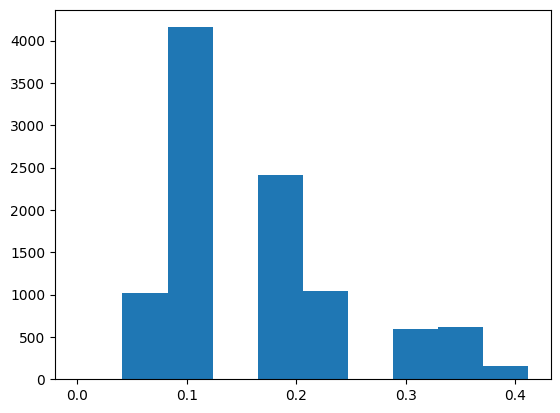

In [68]:
import matplotlib.pyplot as plt

plt.hist(test_probabilities)

In [74]:
threshold = 0.15  # Adjust as needed
test_predictions = (test_probabilities > threshold).astype(int)

print("Predictions complete.")


# Save test predictions
print("Saving test predictions to 'submissions.csv'...")
pd.DataFrame({'id': pd.read_csv('cs-506-predicting-customer-churn-using-knn/test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)
print("Predictions saved successfully.")

Predictions complete.
Saving test predictions to 'submissions.csv'...
Predictions saved successfully.
